In [1]:
import geopandas as gpd
import pandas as pd
from rasterio.mask import mask
import rasterio
import os

In [2]:
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np

In [3]:
from scripts.load_gbif import get_dataframe

In [ ]:
df = get_dataframe()

In [ ]:
df = df[['geometry']]

In [4]:
from shapely.geometry import Point, Polygon
import rasterio

In [ ]:
#shp_file = gpd.read_file("assets\FEATURES\BIOMAS\lm_bioma_250.shp",bbox=(-60, -33.7, -35, -10))

In [5]:
bounds = (-60, -33.7, -35, -10)

class Domain:
    def __init__(
        self,
        bounds: tuple = (-20, -20, 20, 20),
        mask_file: str | None = None,
        input_path: str | None = "",
        output_path: str | None = ""
        ):
        self.minx, self.miny, self.maxx, self.maxy = bounds
        if mask_file:
            try:
                self.geopandas_domain = gpd.read_file(mask_file)
                self.minx, self.miny, self.maxx, self.maxy = self.geopandas_domain.total_bounds
            except Exception as e:
                raise e
        else:
            self.geopandas_domain = None
        self.input_path = input_path
        self.output_path = output_path
        pass
    
    def crop_tiff_with_boundary(self, tiff_file: str, output_file_name: str):
        with rasterio.open(tiff_file) as src:
            # Define a área de interesse como uma geometria
            bbox = [{
                'type': 'Polygon',
                'coordinates': [[
                    (self.minx, self.miny),
                    (self.minx, self.maxy),
                    (self.maxx, self.maxy),
                    (self.maxx, self.miny),
                    (self.minx, self.miny)
                ]]
            }]
            
            # Recorta o arquivo .tiff usando a geometria definida
            out_image, out_transform = mask(src, bbox, crop=True)
            
            # Atualiza os metadados para refletir a nova forma e posição do recorte
            out_meta = src.meta.copy()
            out_meta.update({"driver": "GTiff",
                            "height": out_image.shape[1],
                            "width": out_image.shape[2],
                            "transform": out_transform})
            
            # Salva o recorte em um novo arquivo .tiff
            with rasterio.open(os.path.join(self.output_path,output_file_name), "w", **out_meta) as dest:
                dest.write(out_image)
            print(f"Arquivo criado: {os.path.join(self.output_path,output_file_name)}")
            return os.path.join(self.output_path,output_file_name)
    def get_tiff_masked_data(self, tiff_file: str):
        with rasterio.open(tiff_file) as src:
            # Read the raster data
            data = src.read(1, masked=True)  # Assuming there's only one band, change index if needed
            # Extract metadata for plotting
            transform = src.transform
        return data, transform
    
    def plot_tiff_file(self,tiff_file: str):
        with rasterio.open(tiff_file) as src:
            # Read the raster data
            data = src.read(1, masked=True)  # Assuming there's only one band, change index if needed
            # Extract metadata for plotting
            transform = src.transform
            # Plot the raster data
            
        plt.figure(figsize=(8, 8))
        
        # Plot only the data where it's not no_data
        plt.imshow(np.ma.masked_where(data == src.nodata, data), 
                extent=[transform[2], transform[2] + transform[0] * data.shape[1],
                        transform[5] + transform[4] * data.shape[0], transform[5]],
                cmap='gray')  # Adjust the colormap as needed
        
        plt.xlabel('Longitude')
        plt.ylabel('Latitude')
        plt.title('Cropped GeoTIFF')
        plt.colorbar(label='Value')
        plt.grid(True)
        plt.show()
        
    def crop_and_plot(self, tiff_file,output_file_name):
        tiff_file_path = self.crop_tiff_with_boundary(tiff_file=tiff_file, output_file_name=output_file_name)
        self.plot_tiff_file(tiff_file_path)
        return
    
    def check_if_point_in_dataframe(self, dataframe, shape_dataframe, shape_polygon_col:str='geometry', geometry_col:str = 'geometry'):
        for idx in shape_dataframe.index:
            dataframe.loc[:,idx]= dataframe[geometry_col].map(lambda a: shape_dataframe.loc[idx][shape_polygon_col].contains(a)).copy()
        return dataframe

Arquivo criado: OUTPUT/evenness_01_05_1km_uint16.tif


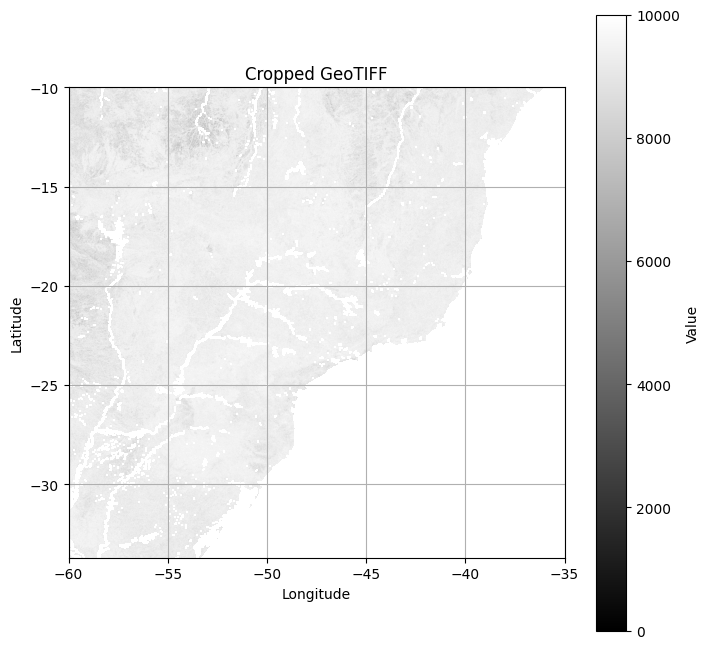

In [6]:
domain = Domain(bounds = bounds, output_path="OUTPUT/")

domain.crop_and_plot("assets\FEATURES\ENHANCED_VEGETATION_INDEX\evenness_01_05_1km_uint16.tif", "evenness_01_05_1km_uint16.tif")

In [ ]:
domain.crop_and_plot("assets\FEATURES\VEGETACAO\evergreen_broadleaf_trees.tif","evergreen_broadleaf_trees.tif")

In [ ]:
import rasterio

def crop_tiff_with_boundary(tiff_file, coords, output_file):
    minx, miny, maxx, maxy = coords
    with rasterio.open(tiff_file) as src:
        # Define a área de interesse como uma geometria
        bbox = [{
            'type': 'Polygon',
            'coordinates': [[
                (minx, miny),
                (minx, maxy),
                (maxx, maxy),
                (maxx, miny),
                (minx, miny)
            ]]
        }]
        
        # Recorta o arquivo .tiff usando a geometria definida
        out_image, out_transform = mask(src, bbox, crop=True)
        
        # Atualiza os metadados para refletir a nova forma e posição do recorte
        out_meta = src.meta.copy()
        out_meta.update({"driver": "GTiff",
                         "height": out_image.shape[1],
                         "width": out_image.shape[2],
                         "transform": out_transform})
        
        # Salva o recorte em um novo arquivo .tiff
        with rasterio.open(output_file, "w", **out_meta) as dest:
            dest.write(out_image)

In [ ]:
crop_tiff_with_boundary(
    tiff_file="assets/FEATURES/TEMPERATURE/wc2.1_30s_bio_1.tif",
    coords=bounds,
    output_file="assets/UTILS/temp_1.tif"
)

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
import numpy as np

def plot_tiff(tiff_file):
    with rasterio.open(tiff_file) as src:
        # Read the raster data
        data = src.read(1, masked=True)  # Assuming there's only one band, change index if needed
        # Extract metadata for plotting
        transform = src.transform

    # Plot the raster data
    plt.figure(figsize=(8, 8))
    
    # Plot only the data where it's not no_data
    plt.imshow(np.ma.masked_where(data == src.nodata, data), 
               extent=[transform[2], transform[2] + transform[0] * data.shape[1],
                       transform[5] + transform[4] * data.shape[0], transform[5]],
               cmap='gray')  # Adjust the colormap as needed
    
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.title('Cropped GeoTIFF')
    plt.colorbar(label='Value')
    plt.grid(True)
    plt.show()

In [ ]:
plot_tiff("assets/UTILS/temp_1.tif")